In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import re
import nltk
from collections import Counter
from nltk.corpus import stopwords
nltk.download('stopwords')

# Define dataset paths and column names
file_map = {
    "train": "drive/MyDrive/sentiment/train.csv",
    "test": "drive/MyDrive/sentiment/test.csv",
    "manual_test": "drive/MyDrive/sentiment/testdata.manual.2009.06.14.csv",
    "full_train": "drive/MyDrive/sentiment/training.1600000.processed.noemoticon.csv"
}
cols = ['polarity', 'id', 'date', 'query', 'user', 'text']

# Load and combine all files
dfs = []
for label, path in file_map.items():
    df = pd.read_csv(path, encoding='latin-1', header=None, names=cols, dtype=str, low_memory=False)
    df['source'] = label
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

# Filter valid polarity values only
df_all = df_all[df_all['polarity'].isin(['0', '2', '4'])]

# Map polarity to sentiment
polarity_map = {'0': 'negative', '2': 'neutral', '4': 'positive'}
df_all['sentiment'] = df_all['polarity'].map(polarity_map)

# Drop null text rows
df_all = df_all.dropna(subset=['text'])

# Clean text function
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www.\S+", "", text)
    text = re.sub(r"@\w+|#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    return text.strip()

# Apply text cleaning and calculate length
df_all['clean_text'] = df_all['text'].apply(clean_text)
df_all['text_length'] = df_all['clean_text'].apply(lambda x: len(x.split()))

# Print sentiment counts by file
print(df_all.groupby(['source', 'sentiment']).size())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


source       sentiment
full_train   negative     799996
             positive     248576
manual_test  negative        178
             neutral         140
             positive        198
dtype: int64


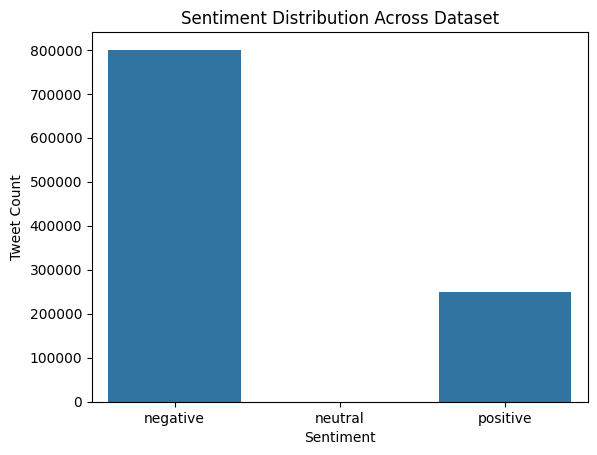

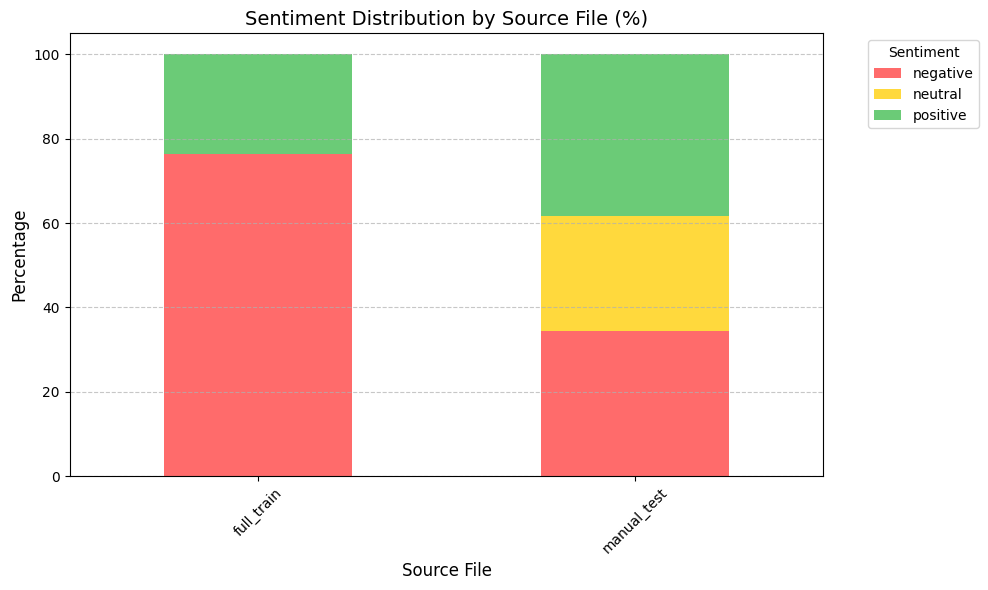

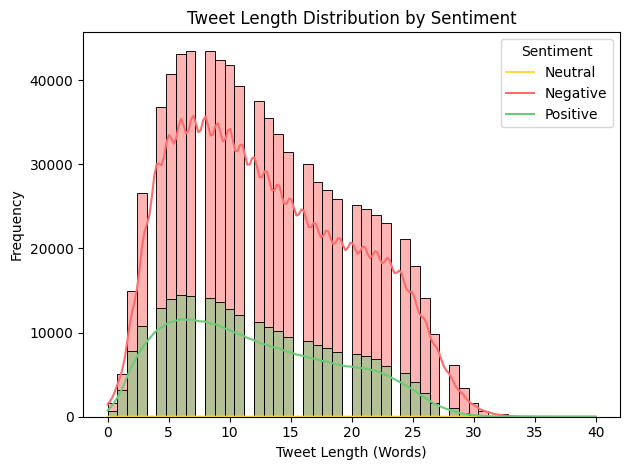

In [6]:
# --- Plotting and EDA ---

# Plot absolute counts
sns.countplot(x='sentiment', data=df_all, order=['negative', 'neutral', 'positive'])
plt.title("Sentiment Distribution Across Dataset")
plt.xlabel("Sentiment")
plt.ylabel("Tweet Count")
plt.show()

# Group by source and sentiment
sentiment_by_file = df_all.groupby("source")["sentiment"].value_counts().unstack().fillna(0)

# Custom color palette
colors = {
    "negative": "#FF6B6B",
    "neutral": "#FFD93D",
    "positive": "#6BCB77"
}
# Plot as a percentage stacked bar plot
sentiment_percent = sentiment_by_file.div(sentiment_by_file.sum(axis=1), axis=0) * 100
sentiment_percent.plot(kind='bar', stacked=True, figsize=(10,6), color=[colors[c] for c in sentiment_percent.columns])

plt.title("Sentiment Distribution by Source File (%)", fontsize=14)
plt.xlabel("Source File", fontsize=12)
plt.ylabel("Percentage", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

sns.histplot(data=df_all[df_all['sentiment'].notna()],
             x='text_length',
             bins=50,
             hue='sentiment',
             kde=True,
             palette={'negative':'#FF6B6B', 'neutral':'#FFD93D', 'positive':'#6BCB77'})
plt.title("Tweet Length Distribution by Sentiment")
plt.xlabel("Tweet Length (Words)")
plt.ylabel("Frequency")
plt.legend(title="Sentiment", labels=["Neutral", "Negative", "Positive"])
plt.tight_layout()
plt.show()

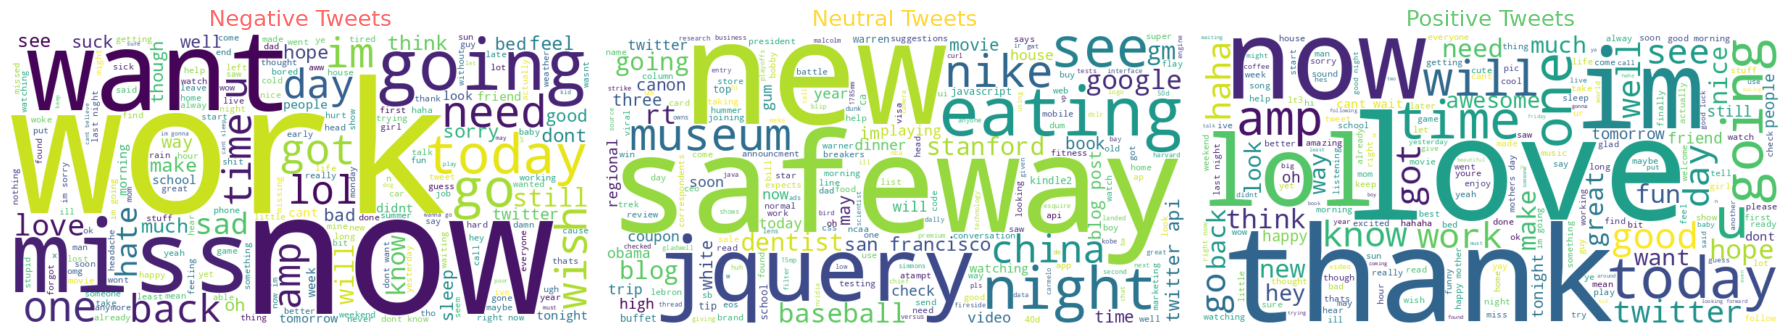

In [7]:
# word clouds
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
sentiments = ['negative', 'neutral', 'positive']
colors = {'negative': '#FF6B6B', 'neutral': '#FFD93D', 'positive': '#6BCB77'}

plt.figure(figsize=(18, 5))
for i, sentiment in enumerate(sentiments):
    text = ' '.join(df_all[df_all['sentiment'] == sentiment]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords, colormap=None).generate(text)
    plt.subplot(1, 3, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"{sentiment.capitalize()} Tweets", fontsize=16, color=colors[sentiment])
    plt.axis('off')
plt.tight_layout()
plt.show()


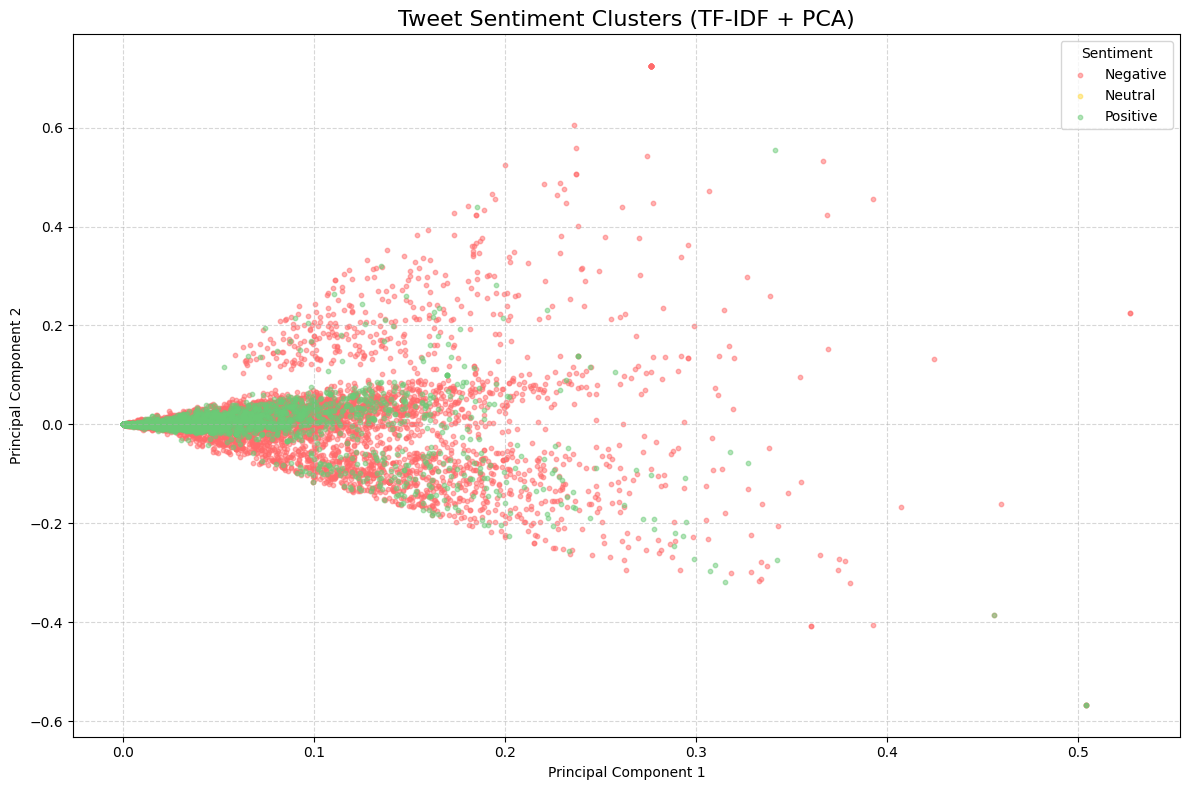

In [8]:
# clustering
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# Filter only valid sentiment rows
df_filtered = df_all[df_all['sentiment'].notna()].copy()

# Optional: sample a subset for visualization (e.g., 10,000 tweets)
sample_size = 10000
df_filtered = df_filtered.sample(n=sample_size, random_state=42)

# TF-IDF Vectorization (limit max_features to control dimensionality)
tfidf = TfidfVectorizer(stop_words='english', max_features=10000)
X_tfidf = tfidf.fit_transform(df_filtered['clean_text'])

# PCA using TruncatedSVD for sparse matrix
pca = TruncatedSVD(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf)

# Encode sentiments for coloring
le = LabelEncoder()
y_encoded = le.fit_transform(df_filtered['sentiment'])
label_names = le.classes_

# Define color palette
palette = {'negative': '#FF6B6B', 'neutral': '#FFD93D', 'positive': '#6BCB77'}

# Plot the PCA result
plt.figure(figsize=(12, 8))
for i, label in enumerate(label_names):
    plt.scatter(X_pca[y_encoded == i, 0], X_pca[y_encoded == i, 1],
                label=label.capitalize(), alpha=0.5, s=10, c=palette[label])

plt.title("Tweet Sentiment Clusters (TF-IDF + PCA)", fontsize=16)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Sentiment")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Number of outliers based on tweet length: 14
Lower Bound: -9.5, Upper Bound: 34.5
                                                     text  text_length
115525  i hope so too  its got to be on a cd somewhere...           35
369155  I never get 2 c u as often as I like,I never g...           37
414684  I feel like a fool he treated me bad damn it w...           35
465254  k so im um now im goin back to sleep... i feel...           35
559392  @LaurenConrad âââ â¥ â¥ â¥ L.A. Candy...           36
565529  Okay I'm Up - I'm Up! Wow, the sun is out, the...           35
615146  So AT&amp;T cnt kp up wit all the tweets I rcv...           36
673178  I stop this and i wish u can talk to me ..And ...           35
708339  Tá»i hum wa mÃ¬nh ko tÃ i nÃ o ngá»§ ÄÆ°á»£c...           36
722380  that is wat alway happen at skool if im  they ...           35


<ipython-input-9-d5053f8bcb16>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_all, x='sentiment', y='text_length', palette=palette)


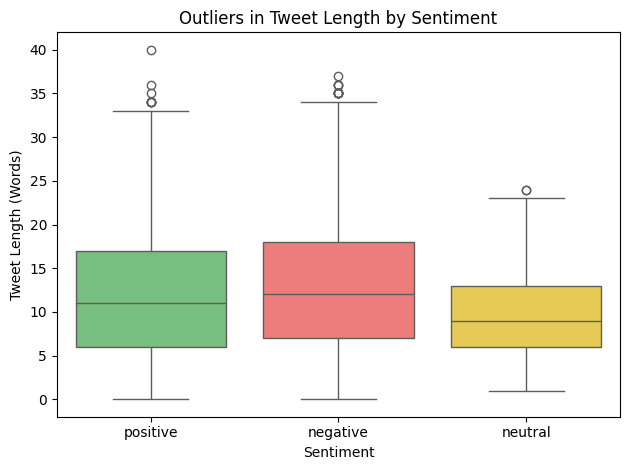

In [9]:
# Outlier Detection using IQR method
Q1 = df_all['text_length'].quantile(0.25)
Q3 = df_all['text_length'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Flagging outliers
df_all['is_outlier'] = (df_all['text_length'] < lower_bound) | (df_all['text_length'] > upper_bound)
num_outliers = df_all['is_outlier'].sum()
print(f"Number of outliers based on tweet length: {num_outliers}")
print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
print(df_all[df_all['is_outlier']][['text', 'text_length']].head(10))


# Define color palette again if not available
palette = {'negative': '#FF6B6B', 'neutral': '#FFD93D', 'positive': '#6BCB77'}

# Boxplot to visualize outliers
sns.boxplot(data=df_all, x='sentiment', y='text_length', palette=palette)
plt.title("Outliers in Tweet Length by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Tweet Length (Words)")
plt.tight_layout()
plt.show()